In [ ]:
# importing the basic packages for data analysis
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import functools
import random

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from scipy.spatial import distance

In [ ]:
folder = '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/'

X = [str(folder+'yes/'+i) for i in os.listdir(folder+'yes')]
Y = [str(folder+'no/'+i) for i in os.listdir(folder+'no')]

In [ ]:
len(X), len(Y)

(155, 98)

In [ ]:
# test X, Y
X[:5], Y[:5]

(['/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y31.jpg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y51.jpg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y184.JPG',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y180.jpg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y181.jpg'],
 ['/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/no/10 no.jpg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/no/11 no.jpg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/no/1 no.jpeg',
  '/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/no/N20.JPG',
  '/content/drive/MyDrive/influence of machine learning in

In [ ]:
# Image standard size setting up
IMAGE_SIZE = 224
# Grand Function to carry out all the preprocessing methods on images using different tensorflow methods and classes
def preprocessing(image_file) :
  '''
  The function takes image file path as input all perform some preprocessing on images like :
  1. Input image using file_path.
  2. Converts image into tensors.
  3. Normalize the tensors from 1-255 to 0-1.
  4. Resize the image into a standard and common size which is 224*224.
  5. Return processed image.
  '''
  # Step 1: access image using file path
  image = tf.io.read_file(image_file)
  # Step 2: Converting numpy from of image into tensors with 3 channels
  image = tf.image.decode_jpeg(image, channels = 3)
  # Step 3: Normalizing the image pixel values.
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Step 4: Resizing all images into a standart shape
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
  
  # Return image
  return image

In [ ]:
# pipeline steps
batch_size = 32
def create_batchs(X):
  data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
  data = data.map(preprocessing).batch(batch_size)
  return data

In [ ]:
X_e = tf.random.shuffle(X)
Y_e = tf.random.shuffle(Y)

X_train = X[35:]
Y_train = Y[20:]

X_test = X[:35]
Y_test = Y[:20]

X_e_train = X_e[35:]
Y_e_train = Y_e[20:]

In [ ]:
X_train[0]

'/content/drive/MyDrive/influence of machine learning in healthcare/brain_tumor_dataset/yes/Y193.JPG'

In [ ]:
X_train_data = create_batchs(X_train)
Y_train_data = create_batchs(Y_train)

X_test_data = create_batchs(X_test)
Y_test_data = create_batchs(Y_test)

X_e_train_data = create_batchs(X_e_train)
Y_e_train_data = create_batchs(Y_e_train)

In [ ]:
print(X_train_data)

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>


In [ ]:
# encoder and decoder networks
n_filters = 12
latent_dim = 100


def encoder(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

def decoder():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  model = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=14*14*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(14, 14, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return model

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = tf.reduce_sum((tf.math.exp(logsigma))+((mu**2)-1-logsigma), axis=0)

  reconstruction_loss = tf.math.reduce_mean(tf.math.abs(x - x_recon))

  vae_loss = (kl_weight*latent_loss)+reconstruction_loss
  
  return vae_loss

def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + (tf.math.exp(z_logsigma)*epsilon)
  return z

def contrastive_loss(image, postive_ex, negative_ex):
  cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
  positive_loss = 1 - cosine_loss(image, postive_ex)
  negative_loss = cosine_loss(image, negative_ex)
  loss = tf.math.exp(positive_loss + negative_loss)
  return loss

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim

    num_encoder_dims = 2*self.latent_dim # +1

    self.encoder = encoder(num_encoder_dims)
    self.decoder = decoder()

  def encode(self, x):
    encoder_output = self.encoder(x)

    z_mean = encoder_output[:, 0:self.latent_dim] 
    z_logsigma = encoder_output[:, self.latent_dim:]

    return z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x): 
    
    z_mean, z_logsigma = self.encode(x)
    
    z =  self.reparameterize(z_mean, z_logsigma)
    
    recon = self.decode(z)
    
    return z_mean, z_logsigma, recon

vae = VAE(latent_dim)

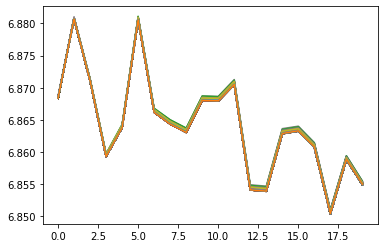

In [ ]:
batch_size = 64
learning_rate = 1e-4
latent_dim = 512

num_epochs = 20

vae = VAE(latent_dim)
optimizer_vae = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def vae_training_step(x, y, z):

  with tf.GradientTape() as tape:
    
    x_mean, x_logsigma, x_recon = vae.call(x)
    y_mean, y_logsigma, y_recon = vae.call(y)
    z_mean, z_logsigma, z_recon = vae.call(z)

    loss_x =  vae_loss_function(x, x_recon, x_mean, x_logsigma)
    loss_y =  vae_loss_function(y, y_recon, y_mean, y_logsigma)
    loss_z =  vae_loss_function(z, z_recon, z_mean, z_logsigma)
    loss = loss_x + loss_y + loss_z + contrastive_loss(x_recon, y_recon, z_recon)

  grads = tape.gradient(loss, vae.trainable_variables)

  optimizer_vae.apply_gradients(zip(grads, vae.trainable_variables))
  return loss

loss_plot = []

for i in range(num_epochs):
  loss = 0
  for j in range(len(X_train)//batch_size): 
    # X as main example
    x = next(X_train_data.as_numpy_iterator())
    y = next(X_e_train_data.as_numpy_iterator())
    z = next(Y_train_data.as_numpy_iterator())
    
    loss += vae_training_step(x, y, z)
    
    # Y as main example
    x = next(Y_train_data.as_numpy_iterator())
    y = next(Y_e_train_data.as_numpy_iterator())
    z = next(X_train_data.as_numpy_iterator())
    loss += vae_training_step(x, y, z)

  loss_plot.append(loss)
plt.plot(loss_plot)
plt.savefig(folder+'learning_curve.png')

In [ ]:
X_samples_train = []
y_train = []

for i in range(len(X_train)):
  x = next(X_train_data.as_numpy_iterator())
  z_mean, z_sigma = vae.encode(x)
  z = vae.reparameterize(z_mean, z_sigma)
  z = tf.reduce_mean(z).numpy()
  X_samples_train.append(z)
  y_train.append(1)

for i in range(len(Y_train)):
  x = next(Y_train_data.as_numpy_iterator())
  z_mean, z_sigma = vae.encode(x)
  z = vae.reparameterize(z_mean, z_sigma)
  z = tf.reduce_mean(z).numpy()
  X_samples_train.append(z)
  y_train.append(0)
  
X_samples_test = []
y_test = []

for i in range(len(X_test)):
  x = next(X_test_data.as_numpy_iterator())
  z_mean, z_sigma = vae.encode(x)
  z = vae.reparameterize(z_mean, z_sigma)
  z = tf.reduce_mean(z).numpy()
  X_samples_test.append(z)
  y_test.append(1)

for i in range(len(Y_test)):
  x = next(Y_test_data.as_numpy_iterator())
  z_mean, z_sigma = vae.encode(x)
  z = vae.reparameterize(z_mean, z_sigma)
  z = tf.reduce_mean(z).numpy()
  X_samples_test.append(z)
  y_test.append(0)

In [ ]:
len(y_test)

55

In [ ]:
y_test[:5], y_test[-5:-1]

([1, 1, 1, 1, 1], [0, 0, 0, 0])

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
lr = RandomForestClassifier()

df_train = pd.DataFrame(list(zip(X_samples_train, y_train)), columns=["z", "y"])
df_test = pd.DataFrame(list(zip(X_samples_test, y_test)), columns=["z", "y"])

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
lr.fit(df_train['z'].values.reshape(-1, 1), df_train['y'].values.reshape(-1, 1))
y_pred = lr.predict(df_test['z'].values.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
accuracy_score(y_pred, df_test['y'].values)

0.6181818181818182

In [ ]:
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])